In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import warnings

from matplotlib import transforms

## Add predictions and ground truth data

In [2]:
variables = ['tas', 'dtr', 'pr', 'pr90']

In [3]:
data_path = 'test/'

Y = xr.open_dataset(data_path + 'outputs_ssp245.nc')
Y["pr"] *= 86400
Y["pr90"] *= 86400

In [4]:
nn_predictions = xr.merge([{v: xr.open_dataarray("CNN_outputs_ssp245_predict_{}.nc".format(v))} for v in variables])
nn_predictions["pr"] *= 86400
nn_predictions["pr90"] *= 86400

In [5]:
proj = ccrs.PlateCarree()

In [6]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    """
    Calculates the T-test for the means of *two independent* samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.

    It is deliberately similar in interface to the other scipy.stats.ttest_... routines

    See e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    and pg. 140 in Statistical methods in Atmos Sciences
    
    :param diff: The mean difference, x_d (|x1 - x1| == |x1| - |x2|)
    :param diff_std: The standard deviation in the difference, s_d (sqrt(Var[x_d]))
    :param diff_num: The number of points, n (n == n1 == n2)
    :return float, float: t-statistic, p-value
    """
    from scipy.stats import distributions

    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    # use np.abs to get upper tail, then multiply by two as this is a two-tailed test
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

p_level = 0.05

## Plot Predictions

[<GeoAxesSubplot: > <GeoAxesSubplot: > <GeoAxesSubplot: >
 <GeoAxesSubplot: >]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


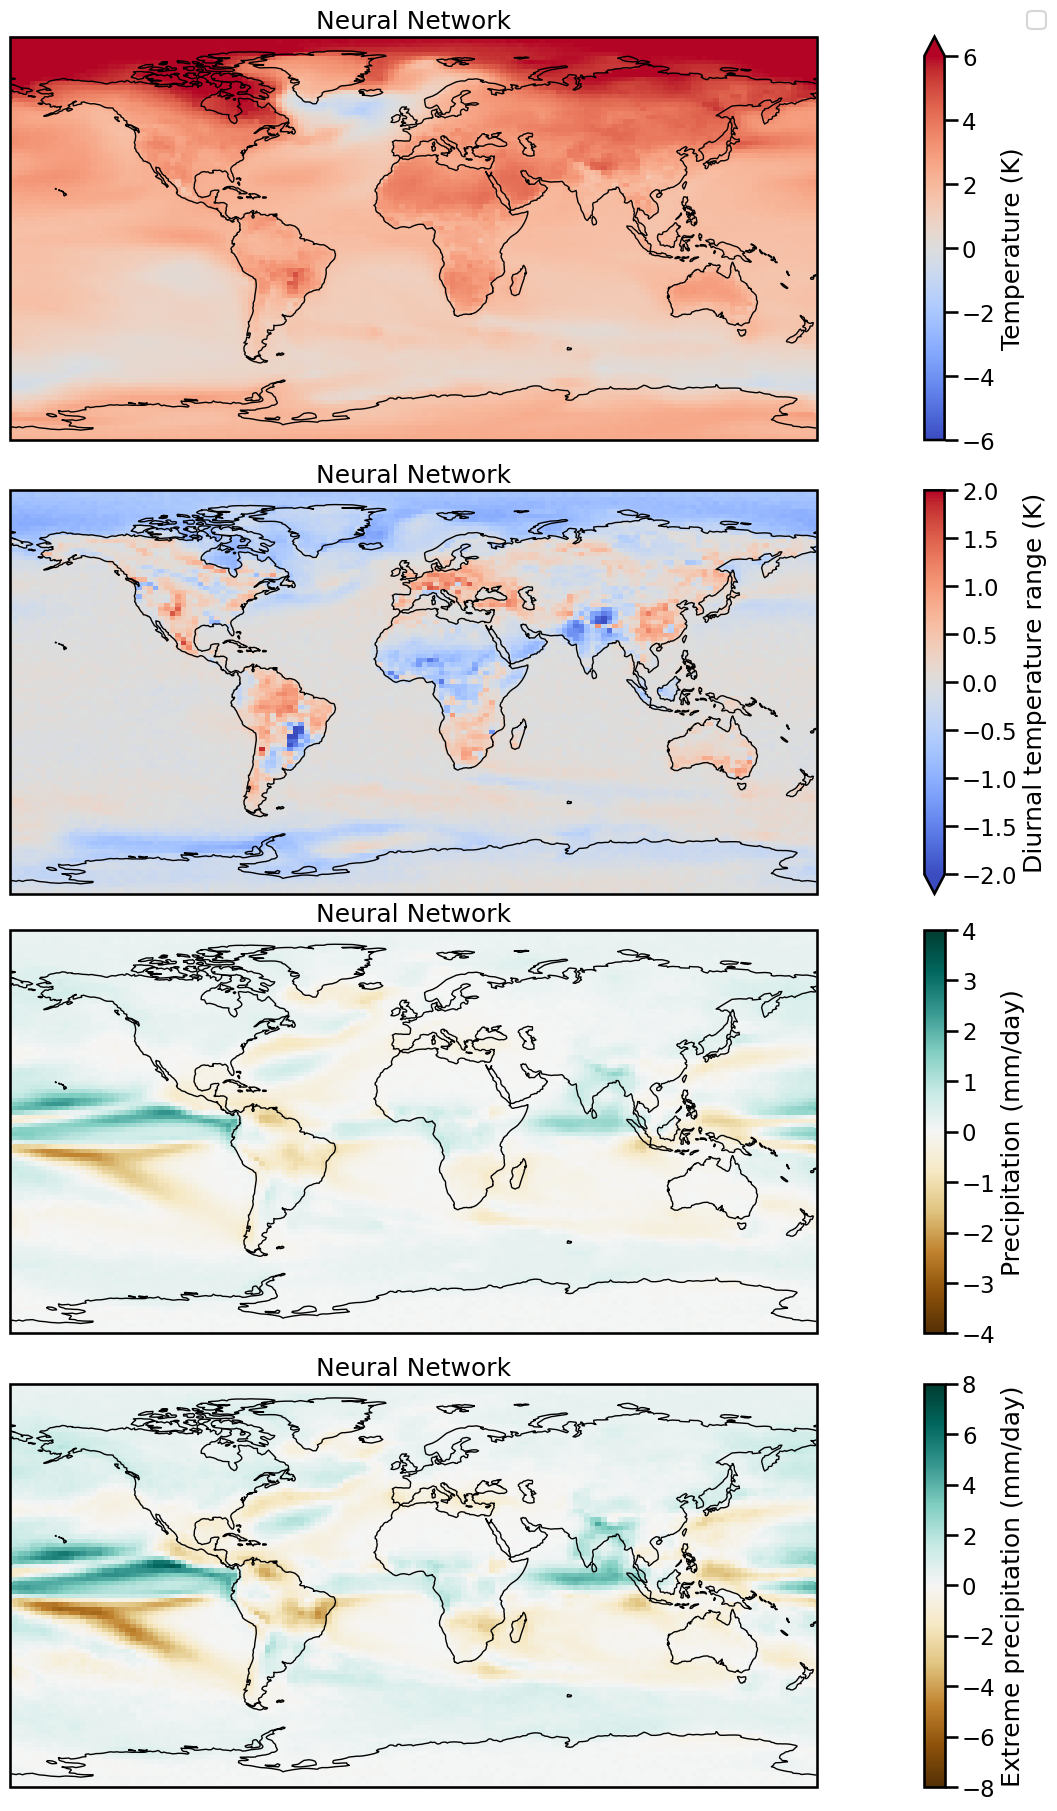

In [7]:
model = nn_predictions
model_label = "Neural Network"
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
kwargs = [dict(cmap="coolwarm", vmax=6), dict(cmap="coolwarm", vmin=-2, vmax=2), dict(cmap="BrBG", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-8, vmax=8)]

with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 1, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for ax, var, label, kws in zip(axes, variables, labels, kwargs):
        model[var].sel(time=slice(2080, \
                                  2100)).mean('time').plot(ax=ax, \
                                                           add_labels=False, \
                                                           transform=ccrs.PlateCarree(), \
                                                           add_colorbar=True, \
                                                           cbar_kwargs={"label": label}, **kws)
        ax.coastlines()
        ax.set_title(model_label)
    fig.legend()
                
    plt.savefig("CNN_plot.png")

## Plot 

[<GeoAxesSubplot: > <GeoAxesSubplot: > <GeoAxesSubplot: >
 <GeoAxesSubplot: >]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


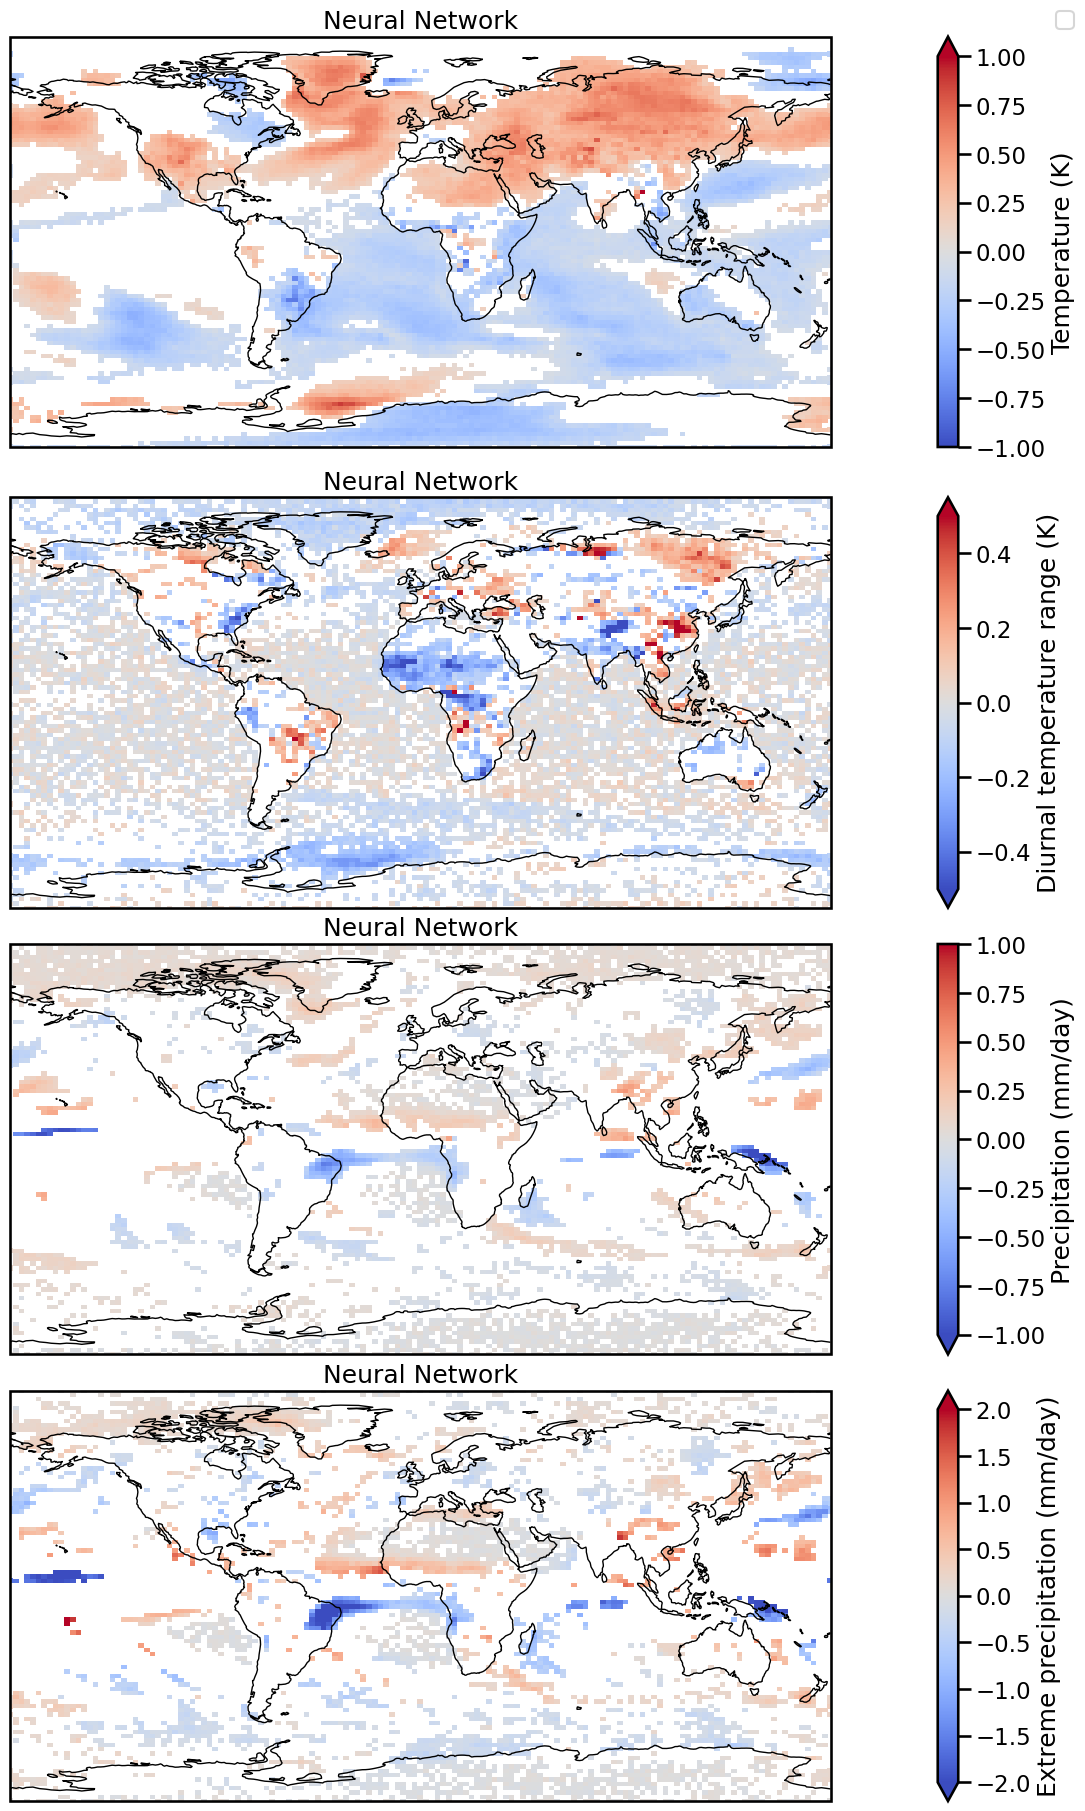

In [8]:
# proj = ccrs.PlateCarree()
kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]

with sns.plotting_context("talk"):
    
    fig, axes = plt.subplots(4, 1, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for ax, var, label, kws in zip(axes, variables, labels, kwargs):
        if var == 'dtr':
            diff = (model[var]-Y.mean('member')['diurnal_temperature_range']).sel(time=slice(2080, 2100))
        else:
            diff = (model[var]-Y.mean('member')[var]).sel(time=slice(2080, 2100))
        mean_diff = diff.mean('time')
        _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
        mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=True, cbar_kwargs={"label": label}, **kws)
        
        ax.set_title(model_label)
        ax.set_ylabel(label)
        ax.coastlines()
    fig.legend()
                
    plt.savefig("CNN_diff.png")